This notebook goes through the entire process of our participation in the AICrowd challenge Road Segmentation. The notebook should be seen as a complement to the final report. It should be noted that even though we compare models in this notebook, the comparisons are not perfect as considerably more time is spent optimizing hyperparameters for the Unet than for the other models.

### Imports and setup

This section contains the essential setup and imports for the project

In [4]:
from baseline.helpers import *
import cv2
import numpy as np
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import segmentation_models as sm
sm.set_framework('tf.keras')
from seg_mod_unet.data_handling import extract_data, extract_data_test, extract_labels
from seg_mod_unet.helpers import patch_to_label, window_predict, img_float_to_uint8, save_predictions, masks_to_submission
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns
# setting the style for plots using seaborn
sns.set()
sns.set_style("white")

Segmentation Models: using `tf.keras` framework.


## Logistic Regression

The first model we implemented to start of the project was a simple logistic regression. The logistic regression extractes 2-dimensional features consisting of average gray color as well as variance from the images. The features are then used to, patch-wise, predict whether a 16x16 patch is road or not 

__Data loading__

In [4]:
# path to original images
image_path = str(Path.cwd()) + "/data/original/images/"

# loading original images
files = os.listdir(image_path)
n = len(files) 
print("Loading " + str(n) + " original images")
imgs = [mpimg.imread(image_path + files[i]) for i in range(n)]

#path to groundtruth images
gt_dir = str(Path.cwd()) + "/data/original/groundtruth/"
print("Loading " + str(n) + " groundtruth images")

# loading groundtruth images
gt_imgs = []
for i in range (n):
    img = mpimg.imread(gt_dir + files[i])
    try:
        gt_imgs.append(img[:,:,0])
    except:
        gt_imgs.append(img)

Loading 100 original images
Loading 100 groundtruth images


__Feature processing__

In [7]:
# defining patchsize to be 16*16 pixels
patch_size = 16 

# extracting patches from the images
img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

# percentage of pixels > 1 required to assign a foreground label to a patch
foreground_threshold = 0.25 

# extracting features from patches
X = np.asarray([extract_features_2d(img_patches[i]) for i in range(len(img_patches))])

# creating label list
Y = np.asarray([value_to_class(np.mean(gt_patches[i]), foreground_threshold) for i in range(len(gt_patches))])

In [8]:
# splitting in training and test set
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

__Model__

In [9]:
# creating logistic regression model
logreg = LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(x_train, y_train)

LogisticRegression(C=100000.0, class_weight='balanced')

In [10]:
# predicting on test set
y_hat = logreg.predict(x_test)

# calculating f1-score for the test set
f1 = f1_score(y_test, y_hat)

print(f'F1-Score: {f1}')

F1-Score: 0.441351888667992


We see that the logistic regression achieves a F1-score of 0.44 on the testset. This is not especially well and supports the hypothesis that a more complex model is needed.

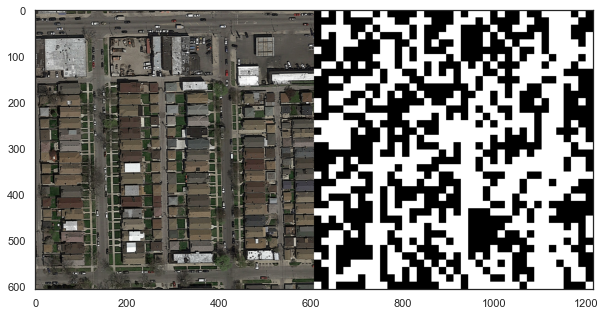

In [14]:
# defining path for one test image and its prediction
test_img_path = "data/training/images/10-split/satImage_095_Aug00"

# reading the test image
test_img = mpimg.imread(test_img_path)
# cropping test image to patches
test_patches = [img_crop(test_img, patch_size, patch_size)]
# linearizing test image
test_patches = np.asarray([test_patches[i][j] for i in range(len(test_patches)) for j in range(len(test_patches[i]))])
# extracting 2d features for test image
X_test = np.asarray([extract_features_2d(img_patches[i]) for i in range(len(img_patches))])

# generating prediction on test image
pred = logreg.predict(X_test)
# converting prediction to image
pred_log = label_to_img(608, 608, patch_size, patch_size, pred)

# saving image
#cv2.imwrite(pred_img_path)

# Visualizing original test image and prediction
cimg = concatenate_images(test_img, pred_log)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

Moreover, from visualizing the image and our prediction, we observe that the model is not especially accurate. 

## Baseline CNN

As we noted above, the logistic regression was not particulary successful. We did therefore decide to implement an improved baseline model. This model is based upon the code given by the course which implements a basic CNN with two convolutional layers and two pooling layers. The code can be found in the baseline.py file in the baseline folder. More information about the model can also be found in the report. All credits for the code is due Aurelien Lucchi from ETH Zürich, we have only made minor modifications. 

First, we run the model on the original dataset. The arguments in the script below specify that the model should indeed be run on the original data

In [1]:
%run "baseline/baseline.py" False

Hei
False
no aug
Number of data points per class: c0 = 92 c1 = 8
Balancing training data...
16
(100, 16, 16, 3)
Number of data points per class: c0 = 8 c1 = 8
Initialized!
Total number of iterations = 7
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Model saved in file: /tmp/segm

c:\Users\Benjamin\Desktop\Skole\EPFL\ml-project-2-vikings_ml\baseline\handling_images.py:186: RuntimeWarning: invalid value encountered in true_divide
  rimg = (rimg / np.max(rimg) * PIXEL_DEPTH).round().astype(np.uint8)


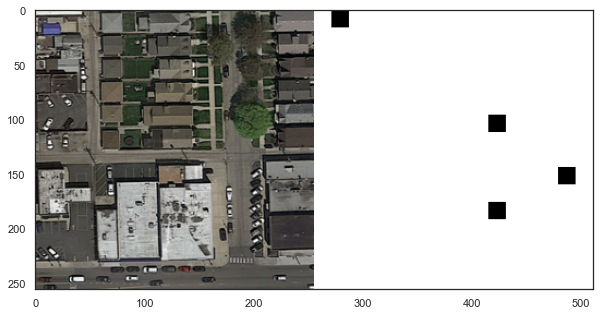

In [5]:
val_img = mpimg.imread("data/training/images/10-split/satImage_095_Aug00.png")
pred_cnn = mpimg.imread("predictions/69.png")
# Visualizing original test image and prediction
cimg = concatenate_images(val_img, pred_cnn)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

We observe that the model do not seem to perform well at all. Especially, it predicts road to scarcely.

In [9]:
# defining paths to save predictions and load groundtruths
pred_path = 'predictions/'
gt_path = 'data/training/groundtruth/10-split/'
files = os.listdir(gt_path)

# lists for storing predictions and groundtruths
preds = []
gts = []

for i in range(len(files)):
    # reading in predicted images
    pred = mpimg.imread(os.path.join(pred_path, '%d.png' % (i+1)))
    # ravelling image to enable calculation of f1-score
    pred = pred.ravel()
    preds.append(pred)

    # repeating the procedure for groundtruth images
    gt = mpimg.imread(os.path.join(gt_path, files[i]))
    gt = gt.ravel()
    gts.append(gt)

# ravelling arrays to calculate f1-score
gts = np.asarray(gts).ravel()
preds = np.asarray(preds).ravel()

# converting grountruths to masks
f = lambda x: 1 if x>0 else 0
gts = np.vectorize(f)(gts)

# calcualting f1-score
f1 = f1_score(gts, preds)

print("The F1-score for the baseline CNN is %.3f"%f1)

The F1-score for the baseline CNN is 0.414


The F1-score for the model on the original data is XX. On AICrowd, it achieved a score of xx. To improve the predictions, we decided to apply feature agumentations. In the cells below, we run exactly the same model, but this time with feature augmentations. 

In [1]:
%run "baseline/baseline.py" True

Running model with data augmentation
Number of data points per class: c0 = 296228 c1 = 95452
Balancing training data...
190904
(391680, 16, 16, 3)
Number of data points per class: c0 = 95452 c1 = 95452
Initialized!
Total number of iterations = 89486
Epoch 0
Minibatch loss: 2.598, learning rate: 0.010000
Minibatch error: 50.0%
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Epoch 1
Minibatch loss: 1.609, learning rate: 0.010000
Minibatch error: 31.2%
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Epoch 2
Minibatch loss: 1.490, learning rate: 0.009500
Minibatch error: 23.4%
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Epoch 3
Minibatch loss: 1.501, learning rate: 0.009025
Minibatch error: 26.6%
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Epoch 4
Minibatch loss: 1.556, learning rate: 0.008574
Minibatch error: 28.1%
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Epoch 5
Minibatch loss: 1.399, learning rate: 0.008145
Minibatch 

In [ ]:
val_img = mpimg.imread("data/training/images/10-split/satImage_095_Aug00")
pred_cnn_aug = mpimg.imread("predictions/69.png")
# Visualizing original test image and prediction
cimg = concatenate_images(val_img, pred_cnn_aug)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [ ]:
# defining paths to save predictions and load groundtruths
pred_path = 'predictions/'
gt_path = 'data/training/images/10-split/'
files = os.listdir(gt_path)

# lists for storing predictions and groundtruths
preds = []
gts = []

for i in range(len(files)):
    # reading in predicted image
    pred = mpimg.imread(os.path.join(pred_path, '%d.png' % (i+1)))
    # ravelling iamge to enable calculation of f1-score
    pred = pred.ravel()

    preds.append(pred)

    # repeating the procedure for groundtruth images
    gt = mpimg.imread(os.path.join(gt_path, files[i]))
    gt = gt.ravel()
    gts.append(gt)

# ravelling arrays to calculate f1-score
gts = np.asarray(gts).ravel()
preds = np.asarray(preds).ravel()

# converting grountruths to masks
f = lambda x: 1 if x>0 else 0
gts = np.vectorize(f)(gts)

# calculating f1-score
f1 = f1_score(gts, preds)

print("The F1-score for the baseline CNN with feature augmentation is %.3f"%f1)

The F1-score for the baseline CNN with feature augmentation is 0.628


## UNet

The next major improvement we got was through the use of a U-net. A description of U-Net can be found in our report. We did first implement the U-net from scratch, but we switched to utlize the segmenation_models library as it was easier to change architecture this way. The follow section contains our segmentation_models implementation, but our first implementation can be found in the seg_mod_unet folder.

**Remark:** The training part of this is originally ran on CoLab and not rewritten for this notebook as it is to time-consuming to run without GPU. It should therefore not be attempted run in this repository. Please, follow the instructions in the README to retrain the model.

__Extracting data and masks__

In [6]:
# Defining paths to images and masks
train_data_path = '/content/data/training/images/'
train_labels_path = '/content/data/training/groundtruth/'

# Extracting the data and masks
x_train = extract_data(train_data_path)
y_train = extract_labels(train_labels_path)

In [7]:
# Splitting the dataset into two, one training set and one validation set
x_val = x_train[1360:]
y_val = y_train[1360:]
x_train = x_train[0:1360]
y_train = y_train[0:1360]

__Model__

In [8]:
# defining backbone for the model
BACKBONE = 'resnet34'
# downloading preprocessing function for the model
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocessing training and validation data
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

In [9]:
# defining model, using 'imagenet' as weights to converge faster
model = sm.Unet(BACKBONE, encoder_weights='imagenet', input_shape=(256, 256, 3))

# adding  L2 kernel regularizer
sm.utils.set_regularization(model, kernel_regularizer=keras.regularizers.l2(1))

# compiling the model using Adam optimizer and Binary Cross Entropy with Jaccard loss
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score, sm.metrics.FScore(),'accuracy'],
)

# saving the model thats scores best on the validation data
callbacks = [keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Models/m6.h5", save_best_only=True)]

# training the model for 50 epochs with batch size = 32
history = model.fit(x=x_train, y=y_train,
   epochs=50, batch_size=32,
   callbacks=callbacks,
   validation_data=(x_val,y_val)
)

85532672/85521592 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/50
43/43 [==============================] - 78s 1s/step - loss: 1.0840 - iou_score: 0.3173 - f1-score: 0.4720 - accuracy: 0.6757 - val_loss: 3.7963 - val_iou_score: 8.4665e-09 - val_f1-score: 1.6905e-08 - val_accuracy: 0.7649
Epoch 2/50
43/43 [==============================] - 46s 1s/step - loss: 0.7195 - iou_score: 0.5270 - f1-score: 0.6897 - accuracy: 0.7358 - val_loss: 2.2874 - val_iou_score: 0.0330 - val_f1-score: 0.0639 - val_accuracy: 0.7649
Epoch 3/50
43/43 [==============================] - 42s 966ms/step - loss: 0.6146 - iou_score: 0.6012 - f1-score: 0.7506 - accuracy: 0.7446 - val_loss: 3.4945 - val_iou_score: 0.0094 - val_f1-score: 0.0187 - val_accuracy: 0.7649
Epoch 4/50
43/43 [==============================] - 41s 964ms/step - loss: 0.5686 - iou_score: 0.6349 - f1-score: 0.7764 - accuracy: 0.7489 - val_loss: 3.7957 - val_iou_score: 1.2973e-06 - val_f1-score: 2.5945e-06 - val_accuracy: 0.7649
Epoch 5/50
43/43 [==============================] - 46s 1s/step - loss: 0.

__Visualizing results__

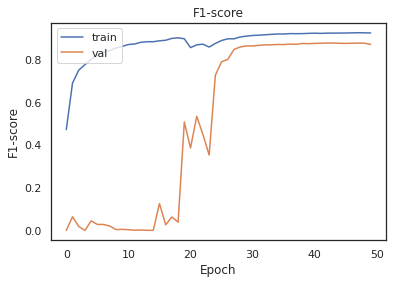

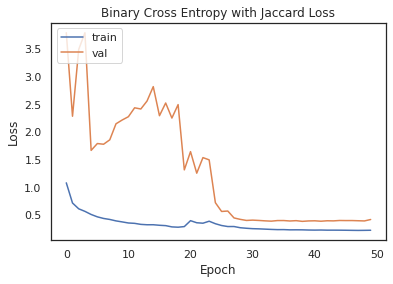

In [23]:
# F1-score for the model across epochs
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('F1-score')
plt.ylabel('F1-score')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('f1_score.png')
plt.show()

# Loss for the model across epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy with Jaccard Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss.png')
plt.show()

We note that the model seem to reach a performance trehshold from around 25 epochs

__Testing__

In [15]:
# generating predictions on the validation set
y_pred = model.predict((x_val))

# defining patch_size to be used in predictions
patch_size = 16

Using validation set to find optimal threshold for defining a patch as road

In [17]:
# defining a list of potential thresholds
thresholds = [0.01*i for i in range(0, 101)]
# list for saving f1-scores
f1s = []
# saving highest f1-score 
highest = 0

# iterating through each threshold and calculating F1-score and accuracy
for thr in thresholds:

  # converting pixelwise predictions to patchwise predictions
  y_pred_flattened = []
  for im in y_pred:
    for j in range(0, im.shape[1], patch_size):
          for i in range(0, im.shape[0], patch_size):
              patch = im[i:i + patch_size, j:j + patch_size]
              label = patch_to_label(patch, thr)
              y_pred_flattened.append(label)
  y_pred_flattened = np.array(y_pred_flattened)

  # converting mask to patchwise values
  y_val_flattened = []
  for im in y_val:
    for j in range(0, im.shape[1], patch_size):
          for i in range(0, im.shape[0], patch_size):
              patch = im[i:i + patch_size, j:j + patch_size]
              label = patch_to_label(patch, thr)
              y_val_flattened.append(label)

  # calculating and storing f1-score and accuracy
  f1 = f1_score(y_val_flattened, y_pred_flattened)
  acc = accuracy_score(y_val_flattened, y_pred_flattened)
  f1s.append(f1)

  # setting foreground_threshold for future predcitions to thr if thr gives the best f1-score
  if f1>highest:
    foreground_threshold=thr

  print("Threshold: %.2f, F1-score: %.4f, Accuracy: %.4f"%(thr, f1, acc))

Threshold: 0.00, F1-score: 0.5233, Accuracy: 0.3543
Threshold: 0.01, F1-score: 0.9750, Accuracy: 0.9844
Threshold: 0.02, F1-score: 0.9763, Accuracy: 0.9855
Threshold: 0.03, F1-score: 0.9765, Accuracy: 0.9859
Threshold: 0.04, F1-score: 0.9764, Accuracy: 0.9860
Threshold: 0.05, F1-score: 0.9773, Accuracy: 0.9866
Threshold: 0.06, F1-score: 0.9774, Accuracy: 0.9868
Threshold: 0.07, F1-score: 0.9767, Accuracy: 0.9866
Threshold: 0.08, F1-score: 0.9766, Accuracy: 0.9866
Threshold: 0.09, F1-score: 0.9774, Accuracy: 0.9872
Threshold: 0.10, F1-score: 0.9776, Accuracy: 0.9875
Threshold: 0.11, F1-score: 0.9775, Accuracy: 0.9875
Threshold: 0.12, F1-score: 0.9778, Accuracy: 0.9878
Threshold: 0.13, F1-score: 0.9779, Accuracy: 0.9879
Threshold: 0.14, F1-score: 0.9771, Accuracy: 0.9876
Threshold: 0.15, F1-score: 0.9765, Accuracy: 0.9874
Threshold: 0.16, F1-score: 0.9760, Accuracy: 0.9872
Threshold: 0.17, F1-score: 0.9754, Accuracy: 0.9871
Threshold: 0.18, F1-score: 0.9753, Accuracy: 0.9871
Threshold: 0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Threshold: 0.99, F1-score: 0.0000, Accuracy: 1.0000
Threshold: 1.00, F1-score: 0.0000, Accuracy: 1.0000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Plotting the F1-score by thresholds

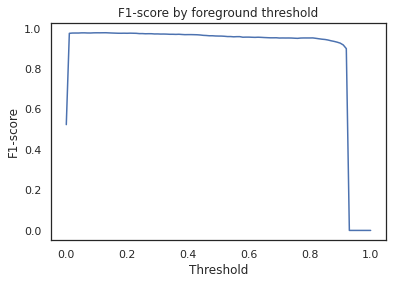

In [22]:
plt.plot(thresholds, f1s)
plt.title("F1-score by foreground threshold")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.savefig("thr.png")
plt.show()

We see that most thresholds score the same, but the optimum (in 0.01 jumps) for this validation set is 0.13.

### Predicting

In [ ]:
# loading the first model as it is not trained on the validation set used in this notebook
model = load_model('/content/drive/MyDrive/Models/m1.h5', custom_objects
                   = {'binary_crossentropy_plus_jaccard_loss':sm.losses.bce_jaccard_loss, 
                      'iou_score': sm.metrics.iou_score, 'f1-score': sm.metrics.FScore()})

In [ ]:
# defining path for thest images
val_dir = os.path.join(os.path.join(str(Path.cwd()), 'data'), 'training') 
val_dir = os.path.join(os.path.join(val_dir, 'images'), '10-split')

In [ ]:
# extracting the validation set
val_images = extract_data_test(val_dir)
# preprocessing the validation images
val_images = preprocess_input(val_images)

In [ ]:
# generating predictions for the test images
results = []
for img in val_images:
    results.append(window_predict(img, model))

In [ ]:
# generating and saving the prediction masks for the testset
for i in range(1, len(results)+1):
  save_predictions(img, 'predictions/test%d'%i)

In [ ]:
# converting pixelwise predictions to patchwise predictions
y_pred_flattened = []
thr = 0.13
for im in y_pred:
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch, thr)
            y_pred_flattened.append(label)
y_pred_flattened = np.array(y_pred_flattened)

In [ ]:
# calculating f1-score
f1 = f1_score(gts, preds)

print("The F1-score for the UNet with resnet34 backbone is %.3f"%f1)

Inspecting the prediction

In [ ]:
val_img = mpimg.imread("data/training/images/10-split/satImage_095_Aug00")
pred_unet = mpimg.imread("predictions/69.png")
# Visualizing original test image and prediction
cimg = concatenate_images(val_img, pred_unet)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')